Bibliotecas

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


Extração

In [ ]:
# URL da API
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json"

# Lendo os dados diretamente da fonte
df_raw = pd.read_json(url)

# Conversão em DataFrame
df_raw = pd.DataFrame(df_raw)
print("✅ Dados extraídos com sucesso.")

# Visualizando as 5 primeiras linhas
df_raw.head()


✅ Dados extraídos com sucesso.


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


Transformação

In [ ]:
# 🔧 TRANSFORMAÇÃO DE DADOS

# 1. Renomeando colunas principais
df = df_raw.rename(columns={
    'customerID': 'customer_id',
    'Churn': 'churn',
    'customer': 'customer_info',
    'phone': 'phone_info',
    'internet': 'internet_info',
    'account': 'account_info'
})

# 2. Expandindo colunas aninhadas
df = df.join(pd.json_normalize(df.pop('customer_info')))
df = df.join(pd.json_normalize(df.pop('phone_info')))
df = df.join(pd.json_normalize(df.pop('internet_info')))
df = df.join(pd.json_normalize(df.pop('account_info')))

# 3. Padronizando nomes
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# 4. Corrigindo tipos de dados
df['charges.monthly'] = pd.to_numeric(df['charges.monthly'], errors='coerce')
df['charges.total'] = pd.to_numeric(df['charges.total'], errors='coerce')
df['tenure'] = pd.to_numeric(df['tenure'], errors='coerce')
df['seniorcitizen'] = df['seniorcitizen'].astype('bool')

# 5. Visualização dos tipos
print("\n📋 Tipos das colunas:")
print(df.dtypes)

print("\n📋 Informações gerais:")
print(df.info())

# 6. Valores nulos
print("\n🔍 Valores nulos por coluna:")
print(df.isnull().sum())

# 7. Duplicatas
print("\n🧹 Duplicatas encontradas:")
print(df.duplicated().sum())

# 8. Erros lógicos
print("\n🔍 Erros lógicos (total < mensal):")
print(df[df['charges.total'] < df['charges.monthly']])

# 9. Tratamento de inconsistências
df = df.dropna(subset=['charges.monthly', 'charges.total', 'tenure'])

# 10. Criando coluna de contas diárias
df.loc[:, 'contas_diarias'] = df['charges.monthly'] / 30

# 11. Normalizando
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['contas_diarias_norm'] = scaler.fit_transform(df[['contas_diarias']])

# 12. Colunas relevantes para churn
colunas_relevantes = [
    'gender', 'seniorcitizen', 'partner', 'dependents',
    'tenure', 'phoneservice', 'internetservice',
    'contract', 'charges.monthly', 'charges.total', 'churn'
]
df_churn = df[colunas_relevantes].copy()

# 13. Dicionário de dados
data_dict = {
    'customer_id': 'ID único do cliente',
    'gender': 'Gênero do cliente',
    'seniorcitizen': 'Se o cliente é idoso (True/False)',
    'partner': 'Se tem parceiro(a)',
    'dependents': 'Se tem dependentes',
    'tenure': 'Meses como cliente',
    'phone_service': 'Se possui serviço telefônico',
    'internet_service': 'Tipo de serviço de internet',
    'contract': 'Tipo de contrato',
    'charges.monthly': 'Valor mensal pago',
    'charges.total': 'Total pago pelo cliente',
    'churn': 'Se o cliente cancelou (Yes/No)'
}

# 14. Churn
print("\n📊 Distribuição de Churn:")
print(df['churn'].value_counts(normalize=True))

print("✅ Transformações aplicadas com sucesso.")



📋 Tipos das colunas:
customer_id          object
churn                object
gender               object
seniorcitizen          bool
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
charges.monthly     float64
charges.total       float64
dtype: object

📋 Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       7267 non-null   object 
 1   churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   senior

Carga e Análise

📌 Dimensões do dataset: (7256, 23)

📌 Tipos de dados:


,0
customer_id,object
churn,object
gender,object
seniorcitizen,bool
partner,object
dependents,object
tenure,int64
phoneservice,object
multiplelines,object
internetservice,object



📌 Estatísticas descritivas (numéricas e categóricas):


,customer_id,churn,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,...,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,charges.monthly,charges.total,contas_diarias,contas_diarias_norm
count,7256,7256,7256,7256,7256,7256,7256.000000,7256,7256,7256,...,7256,7256,7256,7256,7256,7256,7256.000000,7256.000000,7256.000000,7256.000000
unique,7256,3,2,2,2,2,NaN,2,3,3,...,3,3,3,3,2,4,NaN,NaN,NaN,NaN
top,9995-HOTOH,No,Male,False,No,No,NaN,Yes,No,Fiber optic,...,No,No,No,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN
freq,1,5163,3669,6074,3747,5086,NaN,6551,3490,3198,...,3581,2895,2866,4005,4308,2445,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,32.395535,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,64.755423,2280.634213,2.158514,0.462741
std,NaN,NaN,NaN,NaN,NaN,NaN,24.558067,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.125739,2268.632997,1.004191,0.299759
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,18.800000,0.608333,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.450000,400.225000,1.181667,0.171144
50%,NaN,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,70.300000,1391.000000,2.343333,0.517910
75%,NaN,NaN,NaN,NaN,NaN,NaN,55.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,89.900000,3785.300000,2.996667,0.712935



📌 Análise detalhada da fatura mensal:
▶️ Média: 64.76
▶️ Mediana: 70.3
▶️ Desvio padrão: 30.125739077100928

📌 Distribuição do churn:


,proportion
churn,
No,0.711549
Yes,0.257580
,0.030871


/tmp/ipython-input-33-519290622.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='churn', palette='pastel')


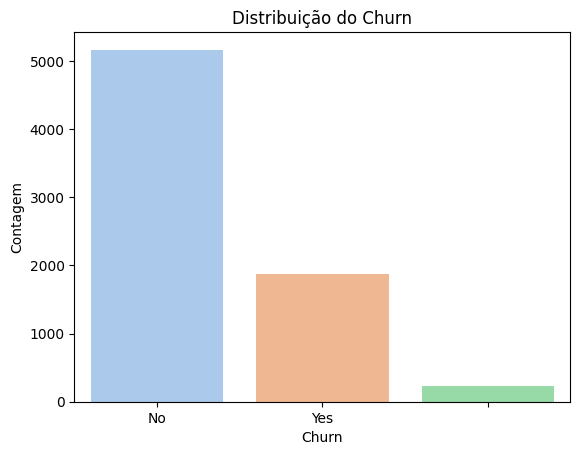


📌 Contagem cruzada entre churn e variáveis categóricas:

🔹 Variável: customer_id


churn,,No,Yes
customer_id,,,
0002-ORFBO,0.0,1.0,0.0
0003-MKNFE,0.0,1.0,0.0
0004-TLHLJ,0.0,0.0,1.0
0011-IGKFF,0.0,0.0,1.0
0013-EXCHZ,0.0,0.0,1.0
...,...,...,...
9987-LUTYD,0.0,1.0,0.0
9992-RRAMN,0.0,0.0,1.0
9992-UJOEL,0.0,1.0,0.0


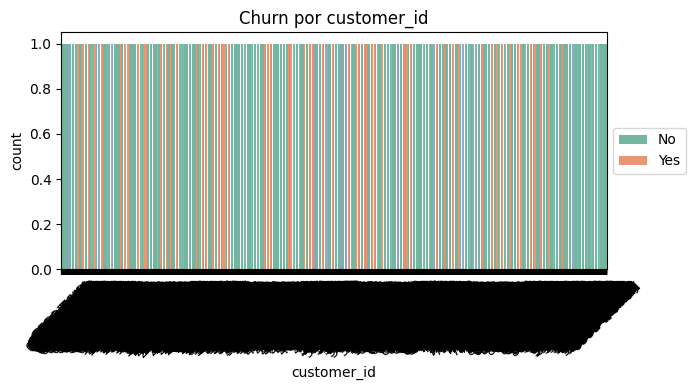


🔹 Variável: gender


churn,,No,Yes
gender,,,
Female,0.028994,0.709228,0.261779
Male,0.032706,0.713818,0.253475


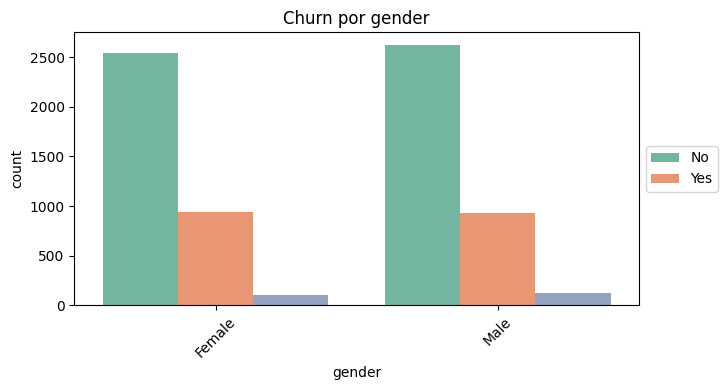


🔹 Variável: seniorcitizen


churn,,No,Yes
seniorcitizen,,,
False,0.030293,0.740369,0.229338
True,0.033841,0.563452,0.402707


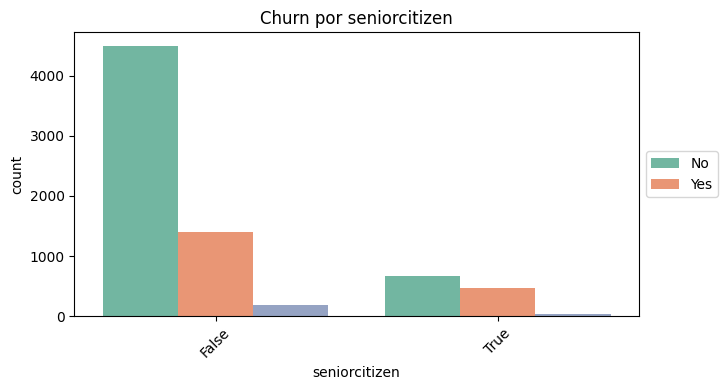


🔹 Variável: partner


churn,,No,Yes
partner,,,
No,0.028823,0.650921,0.320256
Yes,0.033058,0.776290,0.190653


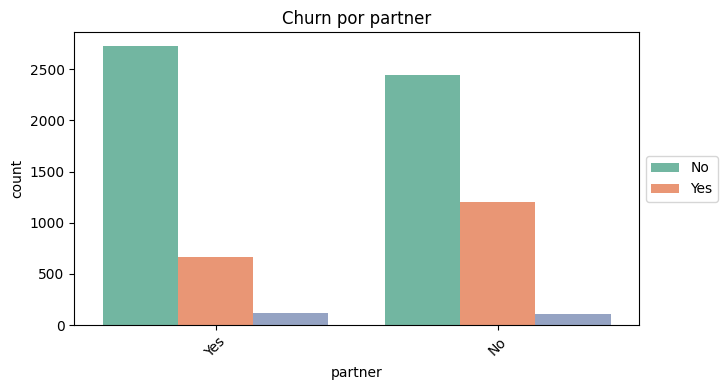


🔹 Variável: dependents


churn,,No,Yes
dependents,,,
No,0.030083,0.666536,0.303382
Yes,0.032719,0.817051,0.150230


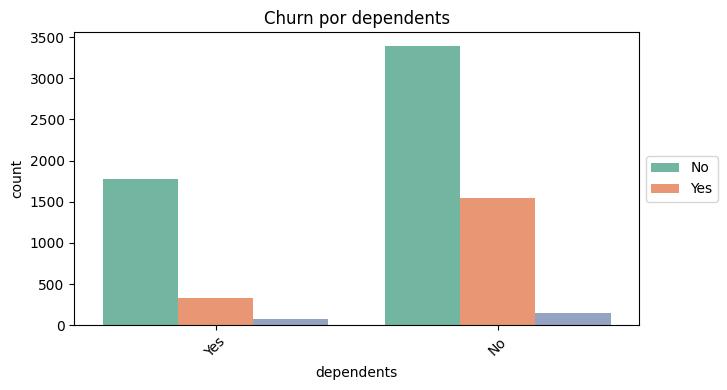


🔹 Variável: phoneservice


churn,,No,Yes
phoneservice,,,
No,0.035461,0.723404,0.241135
Yes,0.030377,0.710273,0.259350


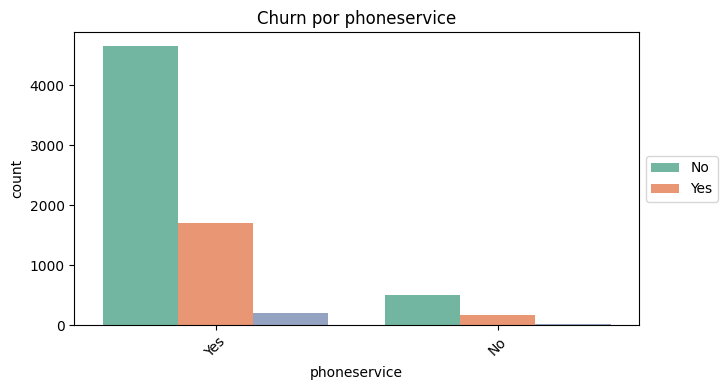


🔹 Variável: multiplelines


churn,,No,Yes
multiplelines,,,
No,0.030086,0.726648,0.243266
No phone service,0.035461,0.723404,0.241135
Yes,0.030709,0.691604,0.277687


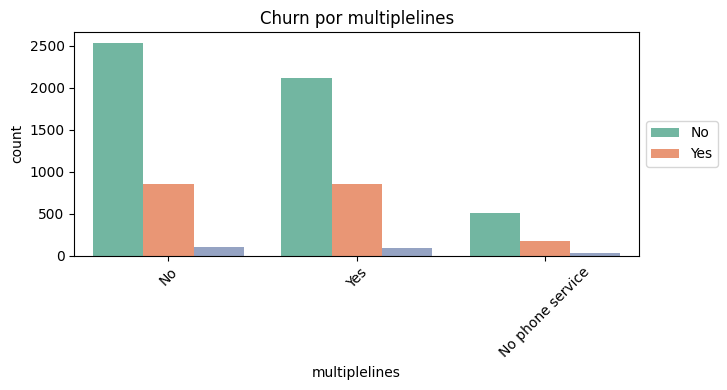


🔹 Variável: internetservice


churn,,No,Yes
internetservice,,,
DSL,0.026983,0.788159,0.184857
Fiber optic,0.031895,0.562539,0.405566
No,0.034921,0.893333,0.071746


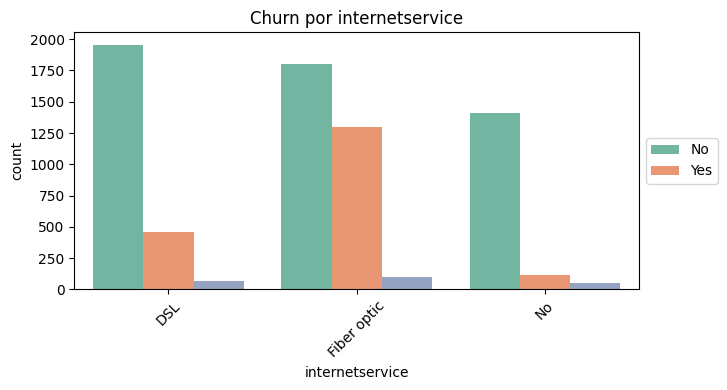


🔹 Variável: onlinesecurity


churn,,No,Yes
onlinesecurity,,,
No,0.030496,0.564458,0.405046
No internet service,0.034921,0.893333,0.071746
Yes,0.028447,0.829315,0.142237


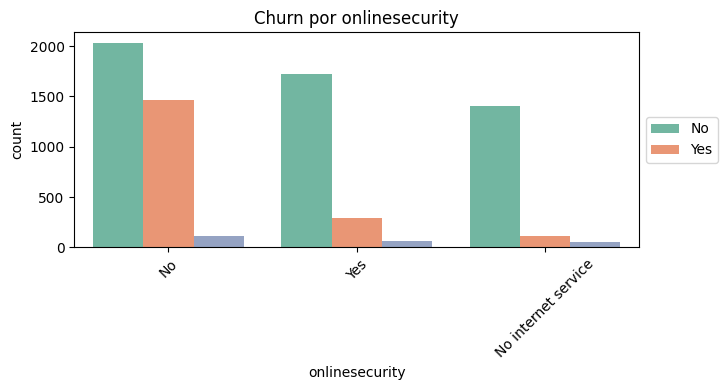


🔹 Variável: onlinebackup


churn,,No,Yes
onlinebackup,,,
No,0.029550,0.582836,0.387614
No internet service,0.034921,0.893333,0.071746
Yes,0.030000,0.760800,0.209200


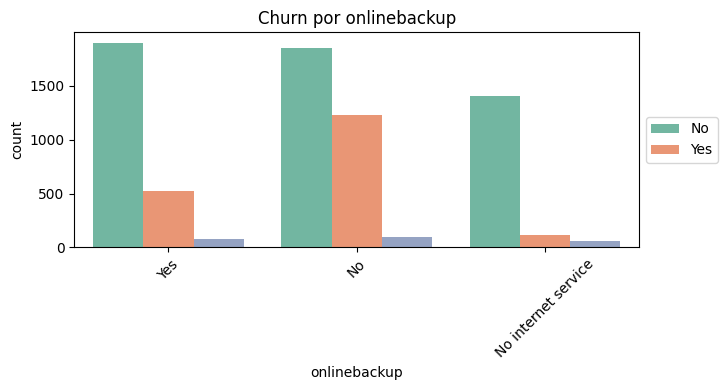


🔹 Variável: deviceprotection


churn,,No,Yes
deviceprotection,,,
No,0.031309,0.589543,0.379148
No internet service,0.034921,0.893333,0.071746
Yes,0.027744,0.753116,0.219140


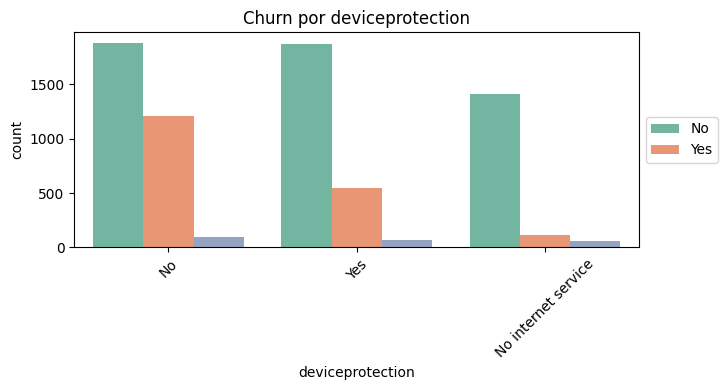


🔹 Variável: techsupport


churn,,No,Yes
techsupport,,,
No,0.030438,0.565764,0.403798
No internet service,0.034921,0.893333,0.071746
Yes,0.028571,0.823810,0.147619


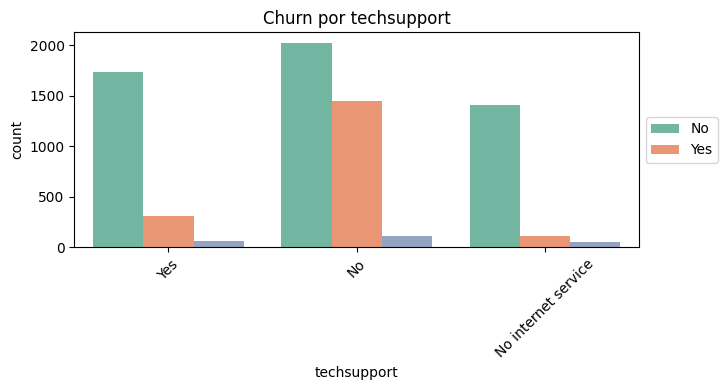


🔹 Variável: streamingtv


churn,,No,Yes
streamingtv,,,
No,0.029706,0.644905,0.325389
No internet service,0.034921,0.893333,0.071746
Yes,0.029792,0.678033,0.292175


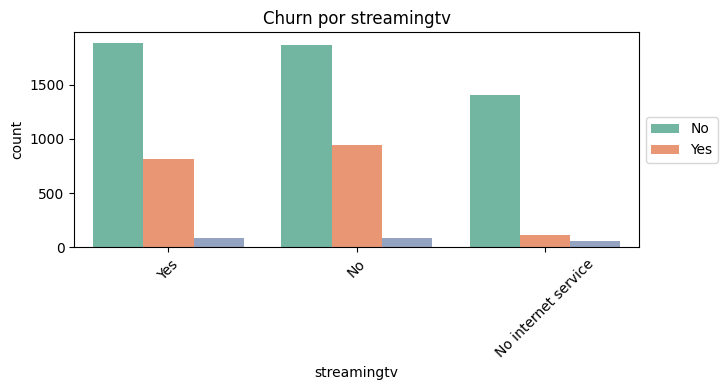


🔹 Variável: streamingmovies


churn,,No,Yes
streamingmovies,,,
No,0.029658,0.643057,0.327285
No internet service,0.034921,0.893333,0.071746
Yes,0.029840,0.679574,0.290586


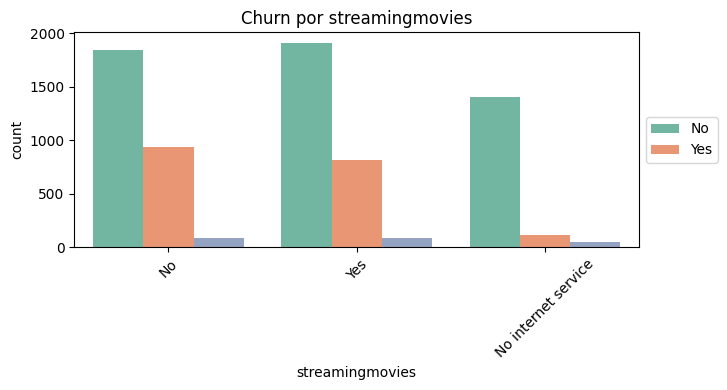


🔹 Variável: contract


churn,,No,Yes
contract,,,
Month-to-month,0.032459,0.554307,0.413233
One year,0.030303,0.860343,0.109354
Two year,0.027698,0.944605,0.027698


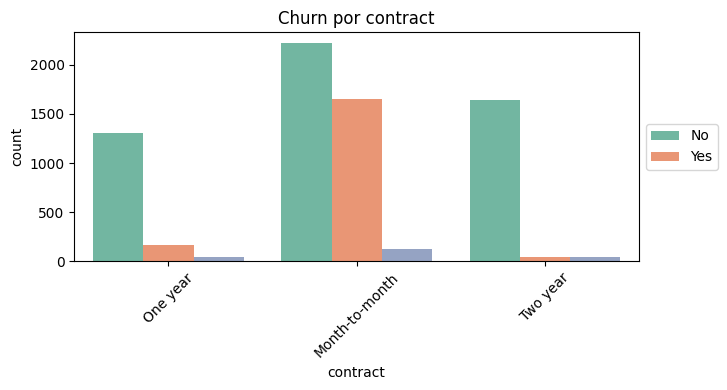


🔹 Variável: paperlessbilling


churn,,No,Yes
paperlessbilling,,,
No,0.028494,0.812415,0.159091
Yes,0.032498,0.642526,0.324977


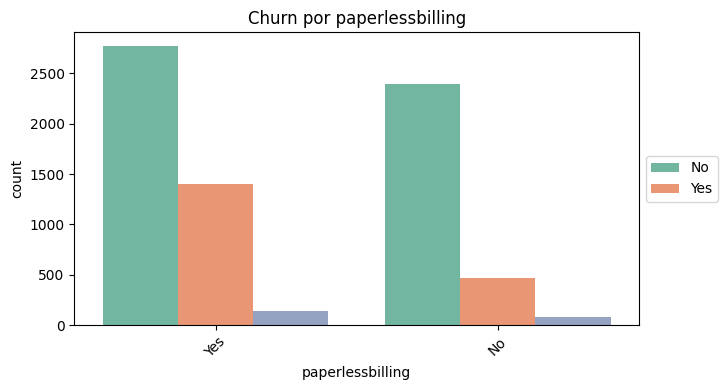


🔹 Variável: paymentmethod


churn,,No,Yes
paymentmethod,,,
Bank transfer (automatic),0.028355,0.809074,0.162571
Credit card (automatic),0.029355,0.822591,0.148054
Electronic check,0.032720,0.529243,0.438037
Mailed check,0.031986,0.782136,0.185878


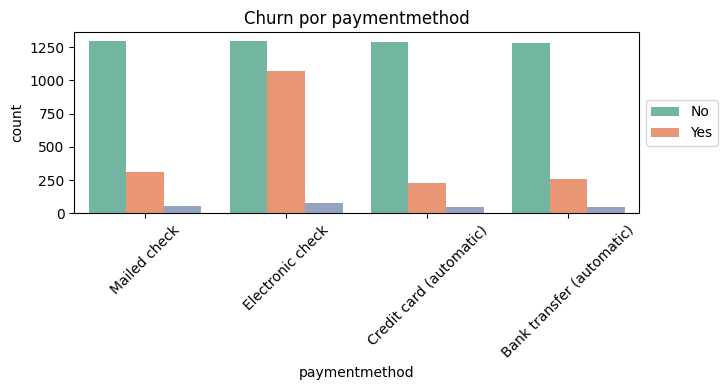


📌 Distribuição das variáveis numéricas:

🔸 Variável: tenure
▶️ Média: 32.39553472987872
▶️ Mediana: 29.0
▶️ Desvio padrão: 24.55806721025508


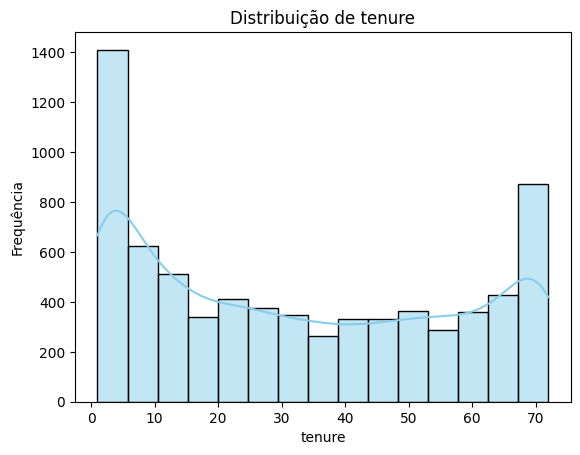


🔸 Variável: charges.monthly
▶️ Média: 64.75542309812569
▶️ Mediana: 70.3
▶️ Desvio padrão: 30.125739077100928


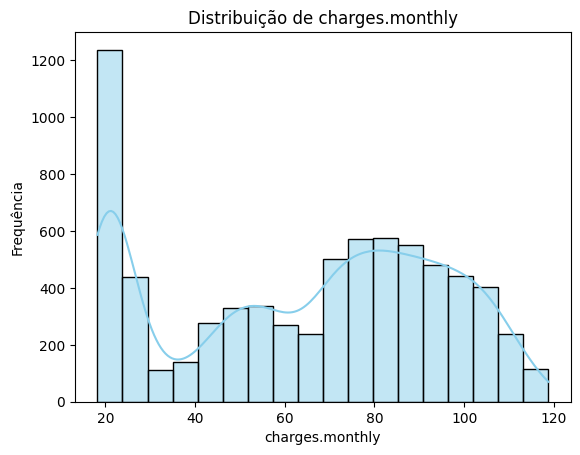


🔸 Variável: charges.total
▶️ Média: 2280.6342130650496
▶️ Mediana: 1391.0
▶️ Desvio padrão: 2268.6329969266067


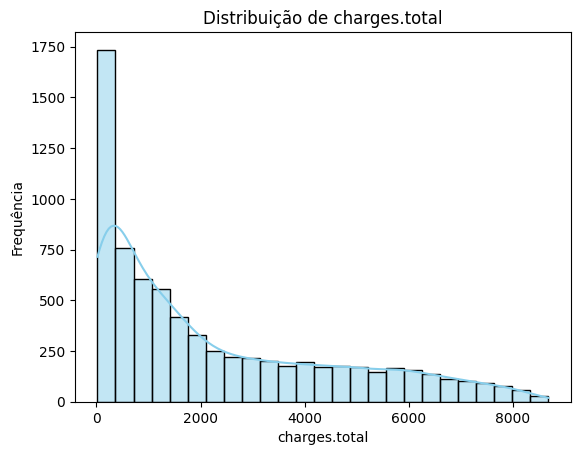


🔸 Variável: contas_diarias
▶️ Média: 2.158514103270856
▶️ Mediana: 2.3433333333333333
▶️ Desvio padrão: 1.0041913025700344


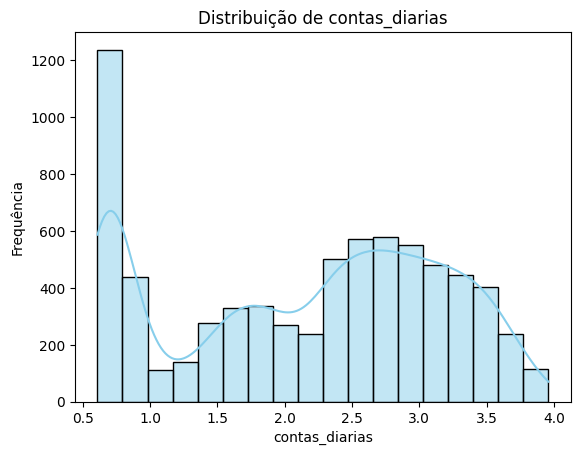


🔸 Variável: contas_diarias_norm
▶️ Média: 0.4627405283395591
▶️ Mediana: 0.517910447761194
▶️ Desvio padrão: 0.2997585977820996


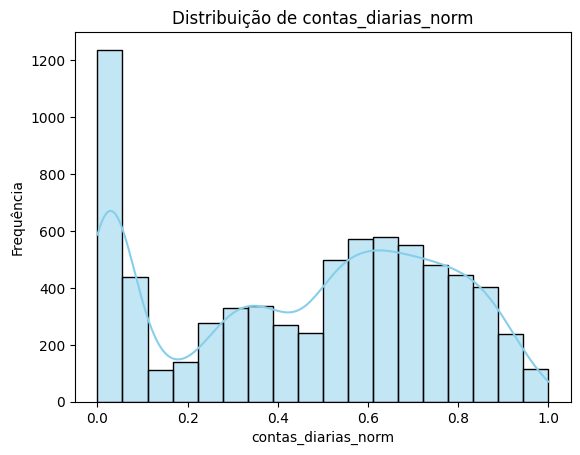


📌 Correlação entre variáveis numéricas:


,tenure,charges.monthly,charges.total,contas_diarias,contas_diarias_norm
tenure,1.000000,0.246981,0.825118,0.246981,0.246981
charges.monthly,0.246981,1.000000,0.652109,1.000000,1.000000
charges.total,0.825118,0.652109,1.000000,0.652109,0.652109
contas_diarias,0.246981,1.000000,0.652109,1.000000,1.000000
contas_diarias_norm,0.246981,1.000000,0.652109,1.000000,1.000000


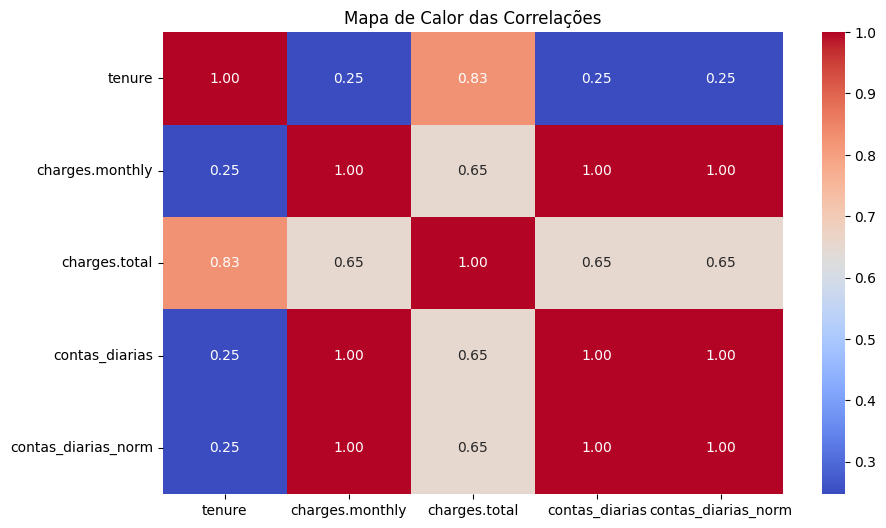

✅ Análise exploratória finalizada com sucesso.


In [ ]:
# 📌 1. Visão geral
print("📌 Dimensões do dataset:", df.shape)
print("\n📌 Tipos de dados:")
display(df.dtypes)

# 📌 2. Estatísticas descritivas gerais
print("\n📌 Estatísticas descritivas (numéricas e categóricas):")
display(df.describe(include='all'))

# 📌 3. Estatísticas específicas
print("\n📌 Análise detalhada da fatura mensal:")
print("▶️ Média:", round(df['charges.monthly'].mean(), 2))
print("▶️ Mediana:", df['charges.monthly'].median())
print("▶️ Desvio padrão:", df['charges.monthly'].std())

# 📌 4. Distribuição do churn
print("\n📌 Distribuição do churn:")
display(df['churn'].value_counts(normalize=True))

# Visualização: Distribuição de Churn
sns.countplot(data=df, x='churn', palette='pastel')
plt.title('Distribuição do Churn')
plt.xlabel('Churn')
plt.ylabel('Contagem')
plt.show()

# 📌 5. Contagem cruzada entre churn e variáveis categóricas
variaveis_categoricas = df.select_dtypes(include=['object', 'bool']).columns.tolist()
variaveis_categoricas.remove('churn')  # removendo a target da comparação

print("\n📌 Contagem cruzada entre churn e variáveis categóricas:")
for var in variaveis_categoricas:
    print(f"\n🔹 Variável: {var}")
    display(pd.crosstab(df[var], df['churn'], normalize='index'))

    # Visualização: Gráfico de barras com tratamento da legenda
    plt.figure(figsize=(8, 4))
    ax = sns.countplot(data=df, x=var, hue='churn', palette='Set2')

    plt.title(f'Churn por {var}')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Ajusta a legenda para fora do gráfico, se necessário
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])  # Reduz o tamanho do gráfico
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Coloca a legenda à direita

    plt.show()

# 📌 6. Distribuição das variáveis numéricas
variaveis_numericas = df.select_dtypes(include='number').columns

print("\n📌 Distribuição das variáveis numéricas:")
for var in variaveis_numericas:
    print(f"\n🔸 Variável: {var}")
    print("▶️ Média:", df[var].mean())
    print("▶️ Mediana:", df[var].median())
    print("▶️ Desvio padrão:", df[var].std())

    # Visualização: Histograma
    sns.histplot(data=df, x=var, kde=True, color='skyblue')
    plt.title(f'Distribuição de {var}')
    plt.xlabel(var)
    plt.ylabel('Frequência')
    plt.show()

# 📌 7. Correlação entre variáveis numéricas
print("\n📌 Correlação entre variáveis numéricas:")
corr = df[variaveis_numericas].corr()
display(corr)

# Mapa de calor da correlação
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor das Correlações")
plt.show()

print("✅ Análise exploratória finalizada com sucesso.")

# 📘 Relatório Final – Análise de Evasão de Clientes (Churn)

---

## 🧭 1. Introdução

A evasão de clientes, ou **churn**, é um dos principais desafios enfrentados por empresas que oferecem serviços recorrentes, como as operadoras de telecomunicações. Clientes que cancelam seus contratos impactam diretamente na receita e no crescimento sustentável do negócio.

Neste projeto, realizamos uma análise completa dos dados da **TelecomX**, com o objetivo de identificar os principais fatores relacionados ao churn e propor estratégias para melhorar a retenção de clientes.

---

## 🧹 2. Limpeza e Tratamento de Dados

Para garantir a qualidade das análises, foi realizado um tratamento completo dos dados:

- **Importação direta** do arquivo JSON hospedado no GitHub.
- **Normalização de colunas aninhadas**, separando os dados de `customer`, `phone`, `internet` e `account`.
- **Padronização de nomes de colunas** para o formato `snake_case`.
- Conversão de colunas como `charges.monthly`, `charges.total` e `tenure` para **valores numéricos**.
- **Eliminação de valores nulos** e registros inconsistentes (ex: quando o valor total era menor que o mensal).
- Criação de uma nova variável chamada `contas_diarias` e sua versão normalizada com `MinMaxScaler`.
- Seleção das colunas mais relevantes para análise de churn.

---

## 📊 3. Análise Exploratória de Dados (EDA)

Realizamos uma série de análises e visualizações para identificar padrões nos dados:

### 📌 Estatísticas Gerais
- **Média da fatura mensal:** R$ 64,76  

- **Mediana:** R$ 70,30  

- **Desvio padrão:** R$ 30,13

### 📈 Gráficos Utilizados:
- **Gráfico de barras** para distribuição do churn.

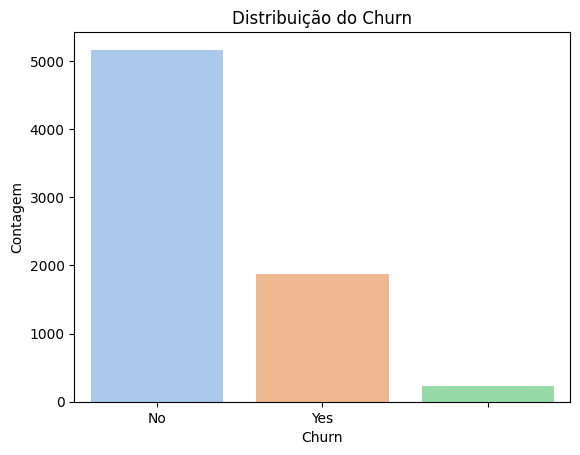
- **Gráficos de contagem (`countplot`)** relacionando churn com variáveis categóricas como:
  - Tipo de contrato

  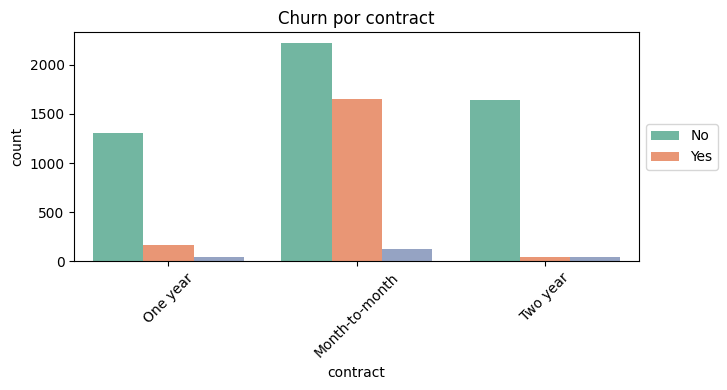
  - Tipo de internet

  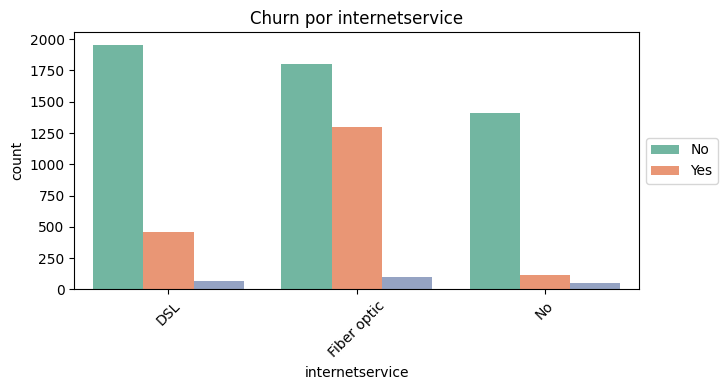
  - Gênero

  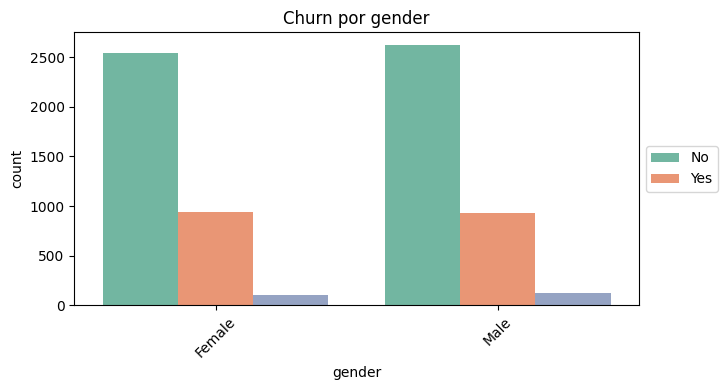
  - Idoso (`SeniorCitizen`)

  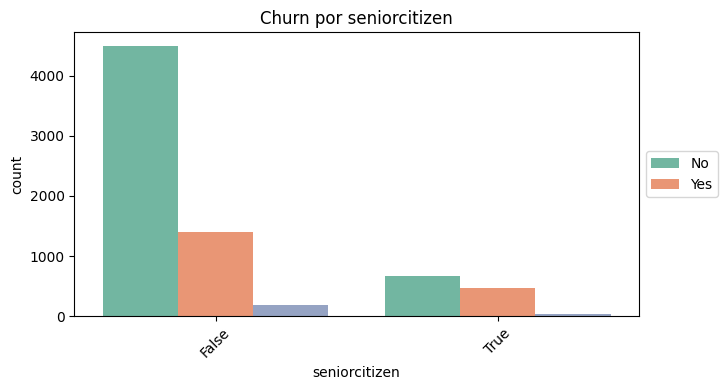
  - Método de pagamento
  
  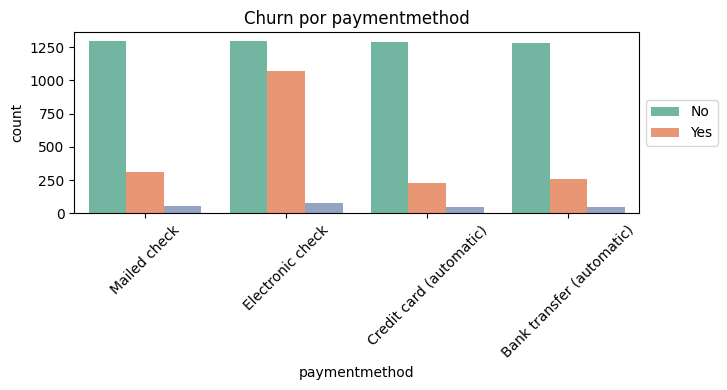
- **Histogramas** para entender a distribuição de variáveis numéricas como `charges.monthly` e `tenure`.

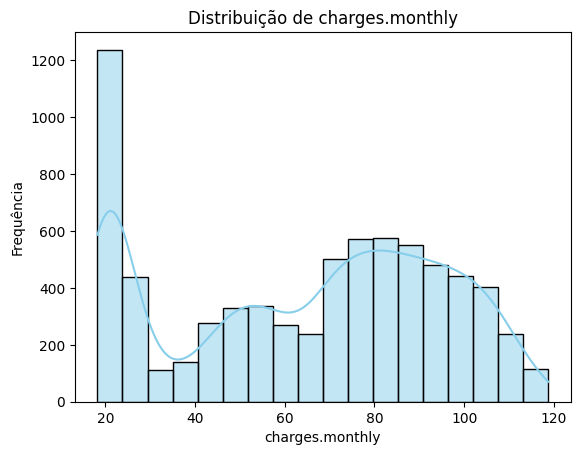

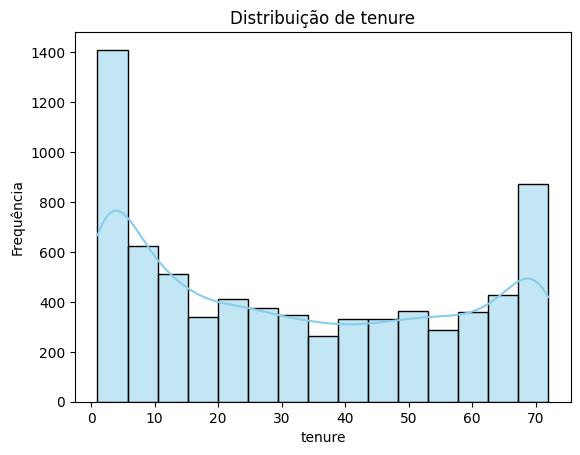
- **Mapa de calor de correlação** entre variáveis numéricas.
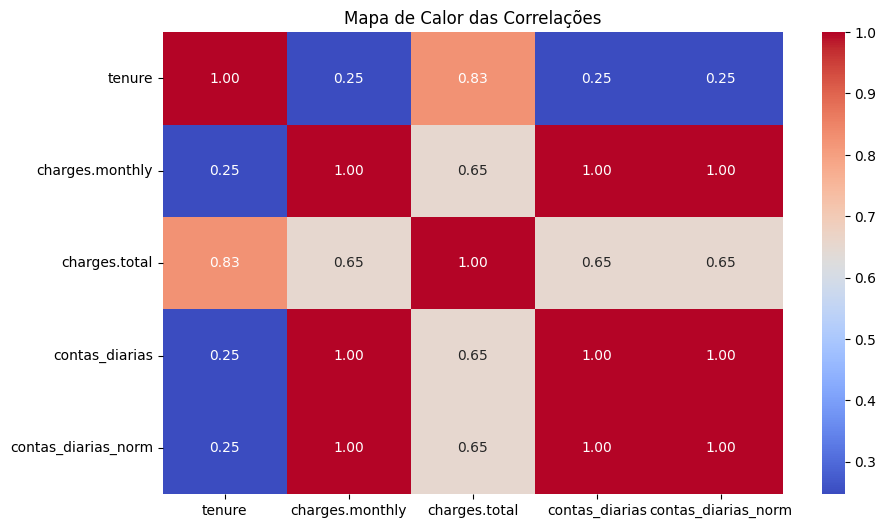
Essas visualizações evidenciaram diferenças claras entre os perfis de clientes que cancelam e os que permanecem.

---

## ✅ 4. Conclusões e Insights

A análise revelou padrões importantes:

- A **maior taxa de churn** está entre clientes com contrato **"Month-to-month"**, ou seja, sem fidelidade.
- Clientes com **menor tempo de permanência** (tenure baixo) estão mais propensos a cancelar.
- Planos com **serviços adicionais** como suporte técnico, backup e segurança tendem a ter menor churn.
- Clientes **idosos** pagam faturas mais altas, mas não apresentam alta evasão — são uma oportunidade de fidelização.
- O **método de pagamento "Electronic check"** está mais associado ao churn.

Esses achados reforçam a importância de segmentar os clientes com base no perfil de risco e oferecer benefícios adequados.

---

## 💡 5. Recomendações

Com base nas análises, propomos as seguintes ações para reduzir a evasão:

1. 🔁 **Incentivar a mudança de contratos mensais para anuais**, com descontos ou recompensas.
2. 🧰 **Oferecer pacotes combinados com segurança, backup e suporte técnico**, especialmente nos planos mais básicos.
3. 🎯 **Criar campanhas de retenção para clientes com menos de 6 meses** de contrato.
4. 💳 **Avaliar o impacto dos métodos de pagamento**, incentivando os mais estáveis (ex: cartão de crédito).
5. 👵 **Atender melhor os clientes idosos**, oferecendo suporte e vantagens para mantê-los na base.

---

## 📌 Encerramento

Este projeto mostrou como uma boa análise exploratória de dados pode revelar padrões ocultos e orientar **decisões estratégicas** voltadas à retenção de clientes. Com a implementação das recomendações, a empresa poderá reduzir significativamente sua taxa de churn e melhorar a satisfação dos seus clientes.
